# Code for the main ML model

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import initializers
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras import optimizers
from sklearn.metrics import mean_absolute_error
import pandas as pd
import numpy as np
import sys
import os
sys.path.insert(0, '../src/')
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

In [2]:
df = pd.read_csv('finaldata_11.csv')
data=np.array(df)
df=df.set_index('Oxides')
df.head()

,Lattice_type,Bulk_Modulus,Density,Heat_capacity,Debye_Temperature,Gruneisen_parameters,Egap,Poisson_ratio,Thermal_expansion,Unitcell_atoms,Speed_of_sound,Thermal_Conductivity
Oxides,,,,,,,,,,,,
Al2Cu2O4,4,165.8100,4.98403,20.4550,590.863,2.01820,2.0150,0.303962,0.000041,8,4275.13,8.57476
K1O3U1,2,127.4920,6.44557,14.0034,408.067,1.94634,3.0113,0.287516,0.000035,5,3508.15,10.41890
Na6O5Pb1,1,59.1269,4.13182,35.7219,386.973,2.21677,1.1163,0.267019,0.000106,12,3119.80,1.94195
C2Ca2O6,7,128.5460,2.58861,25.3634,601.064,1.93522,4.6261,0.338440,0.000040,10,3152.93,5.99870
O1Pb1Sr3,2,38.4608,5.68641,15.2590,254.024,2.10503,0.0000,0.182157,0.000081,5,2637.54,3.77771


In [3]:
df_model = df.iloc[:500,:]
df_test = df.iloc[500:,:]

In [4]:
df_model = df_model.sample(frac=1)

In [5]:
df_model.to_csv("Train_Valid.csv")
df_test.to_csv("Test.csv")

In [6]:
df_train_valid=pd.read_csv('Train_Valid.csv')
df_test=pd.read_csv('Test.csv')

In [7]:
df_train_valid=df_train_valid.sample(frac=1)

In [8]:
all_labels = df_train_valid['Thermal_Conductivity'].tolist()
elements = df_train_valid['Oxides'].tolist()

df_train_valid=df_train_valid.set_index('Oxides')
df_test=df_test.set_index('Oxides')

In [9]:
df_train = df_train_valid.drop(['Thermal_Conductivity'], axis=1)

In [10]:
print(len(df_train))
df_train.head()

500


,Lattice_type,Bulk_Modulus,Density,Heat_capacity,Debye_Temperature,Gruneisen_parameters,Egap,Poisson_ratio,Thermal_expansion,Unitcell_atoms,Speed_of_sound
Oxides,,,,,,,,,,,
O6Sr2Ti2,1,159.720,4.88243,24.54870,648.108,2.03896,2.3866,0.235032,0.000034,10,5114.42
Ba4Mn4O12,4,113.571,5.92248,55.66300,485.858,2.56814,0.6679,0.239317,0.000064,20,3736.76
O8Sn4,6,161.450,6.98984,33.81710,421.858,2.32326,0.1810,0.339683,0.000046,12,2390.81
Ca4O8Pb2,6,106.680,5.83151,39.79530,413.107,2.18196,1.4857,0.287493,0.000056,14,3271.71
O1V1,3,152.360,5.01979,5.06669,607.913,2.06649,0.5352,0.270069,0.000043,2,4497.18


In [11]:
all_values = df_train.to_numpy()
all_values = np.array(all_values, dtype = float) 
all_labels = np.array(all_labels, dtype = float)

order = np.arange(500)
all_values = all_values[order]
all_labels = all_labels[order]

train_labels = all_labels[:400]
train_values = all_values[:400]

validation_labels = all_labels[400:]
validation_values = all_values[400:]

labeled_elements = [elements[x] for x in order[400:]] 
elements = [elements[x] for x in order]

mean = np.mean(train_values, axis = 0) # mean, calculating mean for each row.
std = np.std(train_values, axis = 0) # standard deviation

train_values = (train_values - mean) / std # input scaling
validation_values = (validation_values - mean) / std # input scaling

mean_all = np.mean(all_values, axis = 0) # mean, calculating mean for each row.
std_all = np.std(all_values, axis = 0) # standard deviation
all_values_normalized = (all_values - mean_all) / std_all # input scaling

In [12]:
kernel_init = initializers.RandomNormal(seed=0)
bias_init = initializers.Zeros()
model = Sequential() 
model.add(Dense(16, activation='relu', input_shape=(train_values.shape[1], ), kernel_initializer=kernel_init, 
                bias_initializer=bias_init))
model.add(Dense(32, activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init))
model.add(Dense(128, activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init))
model.add(Dense(1, kernel_initializer=kernel_init, bias_initializer=bias_init))

EPOCHS = 10000 
my_learning_rate = 0.001
my_decay_rate = my_learning_rate / EPOCHS

# CHOOSING THE OPTIMIZER

optimizer = optimizers.legacy.RMSprop(learning_rate=my_learning_rate,decay=my_decay_rate) 
model.compile(loss='mae', optimizer=optimizer, metrics=['mae'])

model.summary()

class PrintEpNum(keras.callbacks.Callback): 
    def on_epoch_end(self, epoch, logs):
        sys.stdout.flush()
        sys.stdout.write("Current Epoch: " + str(epoch+1) + " Training Loss: " + "%4f" %logs.get('loss') 
                         + " Validation Loss: " + "%4f" %logs.get('val_loss')
                         + '                                       \r')


history = model.fit(train_values, train_labels, batch_size=train_values.shape[0], 
                    epochs=EPOCHS, verbose = False, shuffle=False, validation_split=0.1, callbacks=[PrintEpNum()])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16)                192       
                                                                 
 dense_1 (Dense)             (None, 32)                544       
                                                                 
 dense_2 (Dense)             (None, 128)               4224      
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 5,089
Trainable params: 5,089
Non-trainable params: 0
_________________________________________________________________


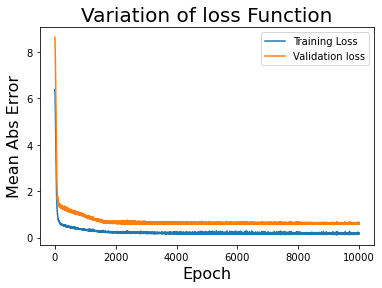

In [13]:
plt.figure(figsize=(6,4))
plt.xlabel('Epoch',fontsize=16)
plt.ylabel('Mean Abs Error',fontsize=16)
plt.plot(history.epoch, np.array(history.history['loss']),label='Training Loss') 
plt.plot(history.epoch, np.array(history.history['val_loss']),label = 'Validation loss')
plt.title("Variation of loss Function",fontsize=20)
plt.legend()
plt.savefig("e.jpg")
plt.show()

13/13 [==============================] - 0s 2ms/step


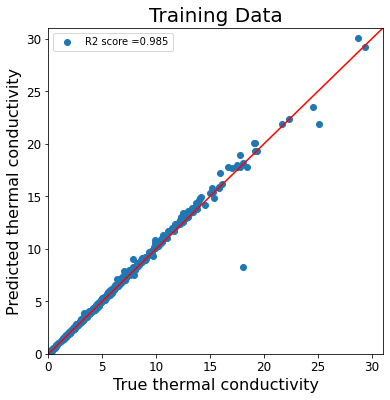

In [14]:
# Check the predictions of training data by the model
train_labels_predict=model.predict(train_values)
plt.figure(figsize=(6,6))
a=r2_score(train_labels,train_labels_predict)
plt.scatter(train_labels,train_labels_predict,label= "R2 score =%1.3f"%a)

plt.ylabel('Predicted thermal conductivity',fontsize=16)
plt.xlabel('True thermal conductivity',fontsize=16)

plt.title("Training Data",fontsize=20)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

t=max(np.max(train_labels),np.max(train_labels_predict))
plt.xlim(0,t+1)
plt.ylim(0,t+1)


plt.axline([0, 0], [1, 1],color='red')
plt.legend()
plt.savefig("f.jpg")
plt.show()

4/4 [==============================] - 0s 2ms/step


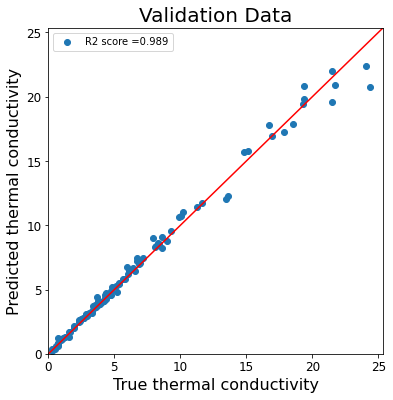

In [15]:
# Check the predictions of training data by the model
validation_labels_predict=model.predict(validation_values)


plt.figure(figsize=(6,6))
a=r2_score(validation_labels,validation_labels_predict)
plt.scatter(validation_labels,validation_labels_predict,label= "R2 score =%1.3f"%a)
plt.ylabel('Predicted thermal conductivity',fontsize=16)
plt.xlabel('True thermal conductivity',fontsize=16)

plt.title("Validation Data",fontsize=20)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

s=max(np.max(validation_labels),np.max(validation_labels_predict))
plt.xlim(0,s+1)
plt.ylim(0,s+1)

plt.axline([0, 0], [1, 1],color='red')
plt.legend()
plt.savefig("g.jpg")
plt.show()

In [16]:
df_test.head()

,Lattice_type,Bulk_Modulus,Density,Heat_capacity,Debye_Temperature,Gruneisen_parameters,Egap,Poisson_ratio,Thermal_expansion,Unitcell_atoms,Speed_of_sound,Thermal_Conductivity
Oxides,,,,,,,,,,,,
Gd4Hf4O14,3,179.0980,8.75272,59.6557,472.100,1.98394,3.4526,0.262282,0.000030,22,3608.19,5.86906
Er4O14Tc4,3,189.8860,7.86351,58.5289,514.094,2.09886,1.2928,0.273255,0.000032,22,3894.06,5.35573
La2O8P2,1,154.4160,4.52769,32.7296,467.070,2.04585,5.3868,0.348994,0.000035,12,3157.69,4.44492
I1K3O1,2,15.8981,2.79143,16.6964,214.127,2.16846,1.0374,0.224335,0.000201,5,2362.76,1.17550
O8P2Sc2,1,193.5810,3.50882,26.3414,797.078,2.00226,4.8968,0.275425,0.000028,12,5161.67,12.73950


In [17]:
k_actual=df_test.iloc[:,-1]

In [18]:
df_test=df_test.drop(['Thermal_Conductivity'],axis=1)

In [19]:
df_test=(df_test - mean) / std
df_test.head()

,Lattice_type,Bulk_Modulus,Density,Heat_capacity,Debye_Temperature,Gruneisen_parameters,Egap,Poisson_ratio,Thermal_expansion,Unitcell_atoms,Speed_of_sound
Oxides,,,,,,,,,,,
Gd4Hf4O14,-0.389557,0.756936,1.307328,1.309792,-0.068310,-0.805110,0.903002,-0.677732,-0.701679,1.243038,0.072521
Er4O14Tc4,-0.389557,0.975929,0.893641,1.252784,0.203478,-0.114551,-0.374350,-0.447203,-0.610063,1.243038,0.347460
La2O8P2,-1.222834,0.255899,-0.658280,-0.052489,-0.100865,-0.433090,2.046930,1.143981,-0.518447,-0.085349,-0.360751
I1K3O1,-0.806196,-2.555968,-1.466039,-0.863663,-1.737932,0.303678,-0.525399,-1.474952,6.721605,-1.015220,-1.125282
O8P2Sc2,-1.222834,1.050936,-1.132288,-0.375690,2.034973,-0.695024,1.757133,-0.401614,-0.810745,-0.085349,1.566595


1/1 [==============================] - 0s 67ms/step


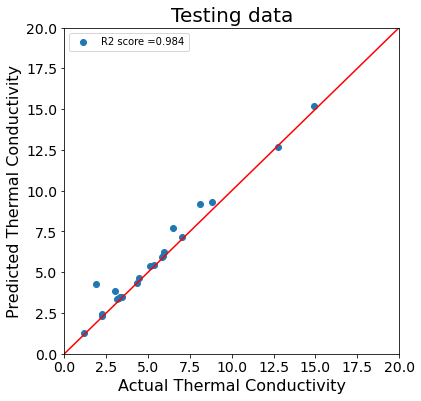

In [20]:
k_predict=model.predict(df_test)

a=r2_score(k_actual,k_predict)

plt.figure(figsize=(6,6))
plt.scatter(k_actual,k_predict,label= "R2 score =%1.3f"%a)
plt.ylabel('Predicted Thermal Conductivity',fontsize=16)
plt.xlabel('Actual Thermal Conductivity',fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

r=max(np.max(k_predict),np.max(k_actual))
plt.xlim(0,r+1)
plt.ylim(0,r+1)

plt.xlim(0,20)
plt.ylim(0,20)
plt.axline([0, 0], [1, 1],color='red')
plt.title("Testing data",fontsize=20)
plt.legend()
plt.savefig("h.jpg")
plt.show()

3/3 [==============================] - 0s 2ms/step


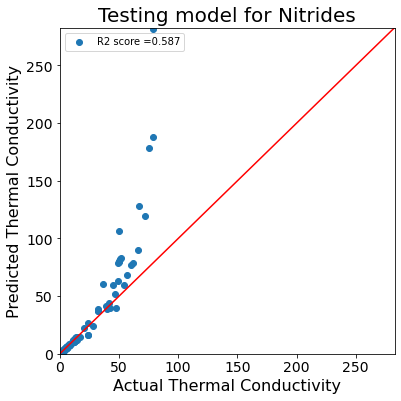

In [21]:
df_N = pd.read_csv("nitrides_11.csv")
df_N=df_N.set_index('Nitrides')
k_N=df_N.iloc[:,-1]
df_N=df_N.drop(['Thermal_Conductivity'],axis=1)
df_N=(df_N - mean) / std
k_predict_N=model.predict(df_N)
a=r2_score(k_N,k_predict_N)

plt.figure(figsize=(6,6))
plt.scatter(k_predict_N,k_N,label= "R2 score =%1.3f"%a)
plt.ylabel('Predicted Thermal Conductivity',fontsize=16)
plt.xlabel('Actual Thermal Conductivity',fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

q=max(np.max(k_N),np.max(k_predict_N))
plt.xlim(0,q+1)
plt.ylim(0,q+1)


plt.axline([0, 0], [1, 1],color='red')
plt.title("Testing model for Nitrides",fontsize=20)
plt.legend()
plt.savefig("i.jpg",dpi=150)
plt.show()

3/3 [==============================] - 0s 2ms/step


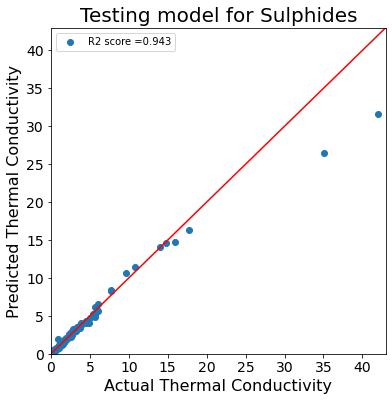

In [22]:
df_S = pd.read_csv("sulphides_11.csv")
df_S=df_S.set_index('Sulphides')
k_S=df_S.iloc[:,-1]
df_S=df_S.drop(['Thermal_Conductivity'],axis=1)
df_S=(df_S - mean) / std
k_predict_S=model.predict(df_S)
a=r2_score(k_S,k_predict_S)

plt.figure(figsize=(6,6))
plt.scatter(k_S,k_predict_S,label= "R2 score =%1.3f"%a)
plt.xlabel('Actual Thermal Conductivity',fontsize=16)
plt.ylabel('Predicted Thermal Conductivity',fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

p=max(np.max(k_S),np.max(k_predict_S))
plt.xlim(0,p+1)
plt.ylim(0,p+1)

plt.axline([0, 0], [1, 1],color='red')
plt.title("Testing model for Sulphides",fontsize=20)
plt.legend()
plt.savefig("j.jpg")
plt.show()